# Imports

In [2]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import itertools
import seaborn as sns
import cv2
import sklearn
from sklearn import datasets
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, log_loss
from functools import partial, lru_cache
from copy import copy

from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer, execute, IBMQ
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.visualization import plot_histogram
from qiskit.extensions.unitary import unitary
from qiskit.tools.monitor import job_monitor
from qiskit.compiler import transpile, assemble
S_simulator = Aer.backends(name = 'statevector_simulator')[0]
M_simulator = Aer.backends(name = 'qasm_simulator')[0]

import functools
from tqdm import tqdm, tqdm_notebook, notebook
from operator import itemgetter

%matplotlib qt
%load_ext jupyternotify

<IPython.core.display.Javascript object>

# Auxiliar functions definition

In [9]:
def preprocess(vector):
    """
    Input: a vector of size m = 2^N with entries in {-1, 1}.
    Output: a (m, 2) numpy array with the form:
    [[1 list([])]
     [-1 list([])]
     [1 list([])]
     [1 list([])]]
    where the frst column represents the sign and the second is the position in binary.
    """
    # Factorize the sign
    i_unsigned = np.multiply(-1, vector)
    # To binary string
    i_binary = [bin(int(n)) for n in i_unsigned]
    # Remove the -0b or 0b par of the binary representation. bin(7) = 0b111 -> 111
    for index, e in enumerate(i_binary):
        if(e[0] == '-'):
            #i_binary[index] = [-1, [int(e) for e in bin(index)[2:]]]
            i_binary[index] = [-1, list(map(int, str(int(bin(index)[2:]))))]
        else:
            #i_binary[index] = [1, [int(e) for e in bin(index)[2:]]]
            i_binary[index] = [1, list(map(int, str(int(bin(index)[2:]))))]
            
    n = int(np.log2(len(i_binary)))
    for index, element in enumerate(i_binary):
        if (len(element[1]) != n):
            while (len(i_binary[index][1]) != n):
                i_binary[index][1].insert(0, 0)
    #for i in range(len(i_binary)):
    #    i_binary[i][1] = i_binary[i][1][::-1]
    i_binary = np.array(i_binary)
    #print(i_binary)
    return i_binary

def check_z(binary):
    """
    Input: a preprocessed vector via preprocess().
    Output: a vector whose entries represents the qubit to perform a Z-gate.
    """
    positive = True # Controls the sign to achieve
    
    if (int(binary[0][0]) < 0):
        positive = False
        
    #print(f'The sign will be positive: {positive}')
    z_index = []
    for index, element in enumerate(binary):
        counts = Counter(element[1])
        #print(counts[1])
        if (counts[1] == 1):
            if (positive):
                if (int(binary[index][0]) == -1):
                    #print(f'Z gate in qubit {np.where(np.array(binary[2**i][1]) == 1)[0]}')
                    z_index.append(int(np.where(np.array(binary[index][1]) == 1)[0][0]))
            else:
                if (int(binary[index][0]) == 1):
                    #print(f'Z gate in qubit {np.where(np.array(binary[2**i][1]) == 1)[0]}')
                    z_index.append(int(np.where(np.array(binary[index][1]) == 1)[0][0]))
    #print(z_index)
    #z_index = reindex(int(np.log2(len(i_binary))), z_index)
    return z_index

def apply_z(binary, Z):
    """
    Input: the preprocessed vector and a vector containing the qubits to apply a Z-gate.
    Output: the resultant vector with the signs flipped accordingly to the action of the Z-gates.
    """
    '''for ind, e in enumerate(binary):
        counts = Counter(e[1])
        if counts[1] > 0:
            ones = np.where(np.array(e[1]) == 1)[0]
            #print(counts[1], e[1], ones)
            for z in Z:
                #print(f'z = {z}, ones = {ones}, changes = {z in ones}')
                if (z in ones):
                    binary[ind][0] *= -1'''
    
    for z in Z:
        mask = np.array(list(map(lambda x : x[z] == 1, binary[:,1])))
        binary[mask, 0] *= -1
    
    #print(binary)
    return binary


def check_cpz(binary):
    """
    Input: the current preprocessed vector.
    Output: the final desired vector and a vector whose elements are vectos containing the qubits to whom apply
            the CPZ.
    """
    CPZ = set()
    n = int(np.log2(len(binary)))
    #print(n)
    sequence = 0
    '''
    # Ordered by the number of ones in its binary representation
    aux_binary = sorted(binary, key = lambda item : Counter(item[1])[1])
    
    # Index holds the positions of the first appearance of n number of ones
    index = []
    cuenta = 1
    for i, e in enumerate(aux_binary):
        if (np.sum(e[1]) > cuenta):
            index.append(i)
            cuenta -= -1
    
    for ind in index: # Now ind holds where in the aux_binary star to appear elements with 2,3,... ones
        for i in range(ind, len(aux_binary)):
            if (aux_binary[i][0] != aux_binary[0][0]):
                ones = np.where(np.array(aux_binary[i][1]) == 1)[0]
                CPZ.add(tuple([sequence, tuple(ones)]))
                sequence -= -1
                
                for j in range(ind, len(aux_binary)):
                    pos = np.where(np.array(aux_binary[j][1]) == 1)[0]
                    pos_set = set(pos)
                    ones_set = set(ones)
                    if (set.issubset(ones_set, pos_set)):
                        aux_binary[j][0] *= -1
        
    
    
    
    '''
    for p in range(2, n + 1):
        for ind, e in enumerate(binary):
            counts = Counter(e[1])
            #print(f'manifold of {p}')
            if (counts[1] == p) and (binary[0][0] != e[0]):
                ones = np.where(np.array(e[1]) == 1)[0]
                #cadena = lambda a : str(a)
                #unos = cadena(ones)[1:-1]
                #CPZ.add(tuple(ones))
                CPZ.add(tuple([sequence, tuple(ones)]))
                #print(f'applying {tuple([sequence, tuple(ones)])} because {e}')
                sequence += 1
                
                ones_set = set(ones)
                mask = np.array(list(map(partial(check_set, ones_set) , binary[:, 1])))
                
                binary[mask, 0] *= -1
                
                #for ind, e in enumerate(binary):
                #    pos = np.where(np.array(e[1]) == 1)[0]
                #    pos_set = set(pos)
                #    ones_set = set(ones)
                #    if (set.issubset(ones_set, pos_set)):
                #        binary[ind][0] *= -1
                        #CPZ.append(ones)
                        #print(f'C{p}Z = {ones}')
    #'''
    #print(binary)
    CPZ = [list(ele) for _, ele in enumerate(CPZ)]
    CPZ = sorted(CPZ, key = lambda l: l[0])
    #print(CPZ)
    CPZ = [list(e[1]) for e in CPZ]
    #sett = [list(e) for e in sett]
    #if(binary[0][0] < 0):
    #    CPZ = list(map(partial(reindex, int(np.log2(len(binary)))), CPZ))
    #CPZ = sorted(CPZ, key = lambda l: (len(l), l.sort()))
    return CPZ

def check_set(ones_set, pos_set):
    return set.issubset(ones_set, set(np.where(np.array(pos_set) == 1)[0]))

def vectorize(number, digits):
    """
    Input: an integer in decimal form and the number of final digits as binary.
    Output: its representation on binary as an array. Most significant bit as first element of the array.
    """
    digits = 2**(np.ceil(np.log2(digits)))
    binary_number = bin(number)[2:]
    as_text = str(binary_number)
    vectorized_number = [int(d) for d in as_text]
    #print(vectorized_number)
    if (digits < len(vectorized_number)):
        digits = 2**(np.ceil(np.log2(len(vectorized_number))))
    if (digits > len(vectorized_number)):
        while (len(vectorized_number) != digits):
            vectorized_number.insert(0, 0)
    #print(vectorized_number)
    return np.array(vectorized_number)

def o_product(i, w):
    return (np.abs(np.dot(i, w))/len(i))**2

def sign(p):
    #Can be substitute in code by:
    #sign = lambda p : [(-1)**i for i in p]
    #list(map(sign, inputs))
    return [(-1)**i for i in p]

def design(p):
    return [1 if i < 0 else 0 for i in w]

def reindex(N, change):
    origin = np.array([i for i in range(N)])
    destiny = np.flipud(origin)
    
    for index, element in enumerate(change):
        #print(f'{element} -> {np.where(d == element)[0]}')
        change[index] = np.where(destiny == element)[0][0]
        
    return change

def U(qc, q, Z, CPZ):
    for z in Z:
        #print(f'Z gate in qubit {type(int(z))}')
        qc.z(q[int(z)])
    for cpz in CPZ:
        controls = [q[int(i)] for i in cpz[:-1]]
        target = q[int(cpz[-1])]
        #print(f'CPZ gate with control {controls} and target {target}')
        qc.h(cpz[-1])
        #qc.mct(controls, target, None, mode='advanced')
        
        #try:
        #    qc.mct(controls, target, None, mode='advanced')
        #except AssertionError:
            #print("Going to mode noancilla")
        qc.mct(controls, target, None, mode='noancilla')
        
        qc.h(cpz[-1])
    return qc

#@lru_cache(maxsize = None)
def gates_sequence(vector):
    #print('Preprocessing')
    binary = preprocess(vector)
    #print('Getting Z gates')
    Z_GATES = check_z(binary)
    #print('Applying Z gates')
    binary = apply_z(binary, Z_GATES)
    #print('Getting CpZ gates')
    CPZ_GATES = check_cpz(binary)
    return Z_GATES, CPZ_GATES

def perceptron(N = 1, shots = 512, z_gates_w = [], CPZ_gates_w = [], z_gates_i = [], CPZ_gates_i = [], simulation = True):
    
    q = QuantumRegister(N, name = 'q_r')
    #A = QuantumRegister(1, name = 'auxiliar_ancillar')
    a = QuantumRegister(1, name = 'a_r')
    c = ClassicalRegister(1, name = 'c_r')
    qc = QuantumCircuit(q, a, c, name = 'qc')

    for index in range(N):
        qc.h(q[index])

        
    qc = U(qc, q, z_gates_i, CPZ_gates_i)
    qc = U(qc, q, z_gates_w, CPZ_gates_w)

    for index in range(N):
        qc.h(q[index])
    
    for index in range(N):
        qc.x(q[index])

    #qc.mct(q[:], a[0], None, mode='advanced')
    
    #try:
    #    qc.mct(q[:], a[0], None, mode='advanced')
    #except AssertionError:
        #print("Going to mode noancilla")
    qc.mct(q[:], a[0], None, mode='noancilla')    
        
    qc.measure(a[0], c)
    #print(qc)
        
    #results = execute(qc, backend = M_simulator, shots = shots).result()
    
    # Optimized
    transpiled_circuit = transpile(qc, M_simulator, optimization_level = 1) # optimization_level = [0, 1, 2, 3]
    job = M_simulator.run(assemble(transpiled_circuit, shots = shots))
    results = job.result()
    
    #results = execute(qc, backend = qcomp, shots = shots, memory=True) # For Real Quantum Computing

    #job_monitor(results) # For Real Quantum Computing
        
    #results = results.result() # For Real Quantum Computing
    
    # Optimized for Real Quantum Computer
    #transpiled_circuit = transpile(qc, qcomp, optimization_level = 2) # optimization_level = 0,1,2,3
    #job = M_simulator.run(assemble(transpiled_circuit, shots = shots))
    #results = job.result()
    
    return results


def fit(qubits = 1, X_train = np.array([[1]]), Y_train = np.array([[1]]), negative_class = 0, positive_class = 1, epochs = 1, shots = 64, threshold = 0.5, Ip = 0.5, In = 0.5, bias = 0, weight_passed = []):
    # Train and return a weight vector
    n = len(X_train)
    result_matrix = np.zeros((epochs, len(X_train)))
    np.random.seed(10)
    
    w = weight_passed
    #w = np.random.randint(2, size = 2**qubits) # Random generation of initial weight vector. Sign it at once.
    
    #w = np.array(X_train[23])
    
    #print(f'Starting training with qubits = {qubits}, train = {X_train}, target = {Y_train}, epochs = {epochs}, shots = {shots}, Ip = {Ip}, In = {In}')
    #print(f'Initial weight vector = {w}')
    
    weights = []
    
    true_labels = np.array([x == number_negative_class for x in Y_train], dtype = 'int')

    for epoch in notebook.tqdm(range(epochs), desc = f'Epoches'):
        errors = 0
        correct = 0
        pred_labels = []
        for index, training_element in enumerate(notebook.tqdm(X_train, desc = f'Training {epoch}')):

            pattern = sign(training_element) # Signing the training pattern.
            
            wei = sign(w) # Signing the weight vector
            #print('Calculating Z gates')
            #print(pattern)
            z_gates_i, CPZ_gates_i = gates_sequence(tuple(pattern)) # Gates to apply to the training pattern vector
            #print('Calculating CpZ gates')
            z_gates_w, CPZ_gates_w = gates_sequence(tuple(wei)) # Gates to apply to the weight vector
            
            #print('Ahora sí, Quantum Realm')
            
            ############################  Quantum Proccess  ############################
            
            results = perceptron(qubits, shots, z_gates_w, CPZ_gates_w, z_gates_i, CPZ_gates_i)
            
            #########################  End of Quantum Proccess  #########################
            
            counts = results.get_counts()
        
            #list_count_value = [ (v,oq.From_binary(k)) for k, v in counts.items()]

            #sorte = sorted(list_count_value, key = itemgetter(0))
        
            #readout = sorte[0][1] * sorte[0][0] / shots
            
            readout = counts.get('1', shots) / shots
            
            '''try:
                readout = (counts['1'] + bias) / shots
            except KeyError:
                readout = 0'''
            
            #print(readout)
            
            clazz = negative_class if readout + 0 * bias < threshold else positive_class # Classification part.
            
            pred_labels.append(clazz)
            
            result_matrix[epoch][index] = readout + 0 * bias
            #print(f'Weight vector = {w} and Training element = {training_element}')
            if (Y_train[index] == clazz):
                # Correctly classified. We do not modify the weight vector and we continue.
                correct -= -np.power(np.inf, np.log(1))
                #if clazz:
                    #Ip *= (n - correct) / float(n)
                    #Ip *= 1.0 / np.log(3 + correct)
                    #Ip *= np.exp(-0.001 * correct)
                    #Ip *= 1.0 / (1.0 + 0.01 * correct)
                    #Ip *= .982**np.floor((correct + 1) / 10)
                #else:
                    #In *= (n - correct) / float(n)
                    #In *= 1.0 / np.log(3 + correct)
                    #In *= np.exp(-0.001 * correct)
                    #In *= 1.0 / (1.0 + 0.01 * correct)
                    #In *= .982**np.floor((correct + 1) / 10)
                continue # Skip the execution to the next iteration
            # If we reach this point the classification was incorrect
            #if (clazz < Y_train[index]): # Classified as 0 (negative) when is 1 (positive)
            if (clazz == negative_class): # Classified as (negative) when is (positive)
                # We flip +-1 signs Ip fraction where i and w coincide
                coincide = np.argwhere(training_element == w).flatten()
                pos = np.array(list(set(np.random.choice(coincide, int(np.floor(len(coincide) * Ip)), replace = False)))) if len(coincide) > 0 else np.array([])
                #print(f'Missclasiffied as 0. Before changes: {Counter(w)} with len(coincide) * Ip = {int(np.ceil(len(coincide) * Ip))}')
                #for indexed in pos:
                    #print('entre en Ip')
                #    w[indexed] = (w[indexed] + 1) % 2
                #print(f'Coincide in {len(coincide)} and change {len(pos)} bits')
                try:
                    w[pos] = (w[pos] + 1) % 2
                except IndexError:
                    pass
                #print(f'Missclasiffied as 0. After  changes: {Counter(w)} with len(coincide) * Ip = {int(np.ceil(len(coincide) * Ip))}')
            else: # Classified as 1 (positive) when is 0 (negative)
                # We flip +-1 signs In fraction where i and w coincide
                coincide = np.argwhere(training_element == w).flatten()
                pos = np.array(list(set(np.random.choice(coincide, int(np.floor(len(coincide) * In)), replace = False)))) if len(coincide) > 0 else np.array([])
                #print(f'Missclasified as 1. Before changes: {Counter(w)} with len(coincide) * In = {int(np.ceil(len(coincide) * In))}')
                #for indexed in pos:
                    #print('entre en In')
                #    w[indexed] = (w[indexed] + 1) % 2
                #print(f'Coincide in {len(coincide)} and change {len(pos)} bits')
                try:
                    w[pos] = (w[pos] + 1) % 2
                except IndexError:
                    pass
                #print(f'Missclasified as 1. After  changes: {Counter(w)} with len(coincide) * In = {int(np.ceil(len(coincide) * In))}')
            errors -= -1
        print(f'Errors = {errors} for accuracy of = {1 - errors/len(X_train)}')
        #print(f'Final weight vector = {w}')
        weights.append(w)
        pred_labels = np.array([x == number_negative_class for x in pred_labels], dtype = 'int')
        loss = 0 if number_negative_class == number_positive_class else log_loss(true_labels, pred_labels) 
    return w, result_matrix, weights, (1 - errors/len(X_train) , loss)

def predict(qubits = 1, X_test = np.array([[1]]), negative_class = 0, positive_class = 1, shots = 64, threshold = 0.5, w = 0, bias = 0):
    # Train and return a weight vector
    result_matrix = np.zeros(len(X_test))
    readout_matrix = np.zeros(len(X_test))
    np.random.seed(10)
    Y_predicted = np.zeros(len(X_test))
    wei = sign(w) # Signing the weight vector
    z_gates_w, CPZ_gates_w = gates_sequence(tuple(wei)) # Gates to apply to the weight vector
    
    #print(f'Starting predict with qubits = {qubits}, train = {X_test}, shots = {shots}')
    #print(f'Passed weight vector = {w}')
         
    for index, training_element in enumerate(notebook.tqdm(X_test, desc = 'Predicting')):
            
        pattern = sign(training_element) # Signing the training pattern.
            
        z_gates_i, CPZ_gates_i = gates_sequence(tuple(pattern)) # Gates to apply to the training pattern vector
            
        ############################  Quantum Proccess  ############################
            
        results = perceptron(qubits, shots, z_gates_w, CPZ_gates_w, z_gates_i, CPZ_gates_i)
            
        #########################  End of Quantum Proccess  #########################
            
        counts = results.get_counts()
        
        #list_count_value = [ (v,oq.From_binary(k)) for k, v in counts.items()]

        #sorte = sorted(list_count_value, key = itemgetter(0))
        
        #readout = sorte[0][1] * sorte[0][0] / shots
        
        readout = counts.get('1', shots) / shots
        
        '''try:
            readout = (counts['1'] + bias) / shots
        except KeyError:
            readout = 0'''
        
        #print(readout)
            
        clazz = negative_class if readout + 0 * bias < threshold else positive_class # Classification part.
            
        result_matrix[index] = clazz
        
        readout_matrix[index] = readout + 0 * bias

    return result_matrix, readout_matrix

def evaluate(Y_test, predicted, negative_class, positive_class):
    correct = np.argwhere(Y_test == predicted)
    accuracy = len(correct) / len(predicted)
    ones_and_zeros = [Y_test[ind][0] for ind in correct]
    counts = Counter(ones_and_zeros)
    confusion_matrix = np.zeros((2,2))
    
    Y_test_aux = np.zeros_like(Y_test)
    predicted_aux = np.zeros_like(predicted)
    
    #Y_test_aux[Y_test == negative_class] = 0
    #predicted_aux[predicted == negative_class] = 0
    Y_test_aux[Y_test == positive_class] = 1
    predicted_aux[predicted == positive_class] = 1
    
    for i in range(len(predicted_aux)):
        confusion_matrix[int(Y_test_aux[i])][int(predicted_aux[i])] += 1
    return accuracy, counts, confusion_matrix

def plot_confusion_matrix(cm, target_names = None, cmap = None, normalize = True, labels = True, title = 'Confusion Matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    
    if cmap is None:
        cmap = plt.get_cmap('Blues')
        
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        
    plt.figure(figsize = (8, 6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
        
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]), horizontalalignment = 'center', color = 'white' if cm[i, j] > thresh else 'black', fontsize = 20)
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]), horizontalalignment = 'center', color = 'white' if cm[i, j] > thresh else 'black', fontsize = 20)
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy = {:0.4f}; misclass = {:0.4f}'.format(accuracy, misclass))
    plt.axis('equal')
    plt.show()
    
def save_weight(filename = 'weights.txt', mode = 'a+', weight = []):
    with open(filename, mode) as file:
        file.write(f'{number_negative_class, number_positive_class}:')
        for p in w:
            file.write(f'{p},')
        file.write('\n')
        
def retrieve_weights_from_file(filename = 'weights.txt', full = False):
    with open(filename, 'r+') as file:
        lines = file.readlines()
        
        cuadratic = lambda w : int(np.abs((1 - np.sqrt(1 + 8 * w)) / 2))
        
        nc = int(np.sqrt(len(lines))) if full else cuadratic(len(lines))
        
        weights_matrix = np.empty((nc, nc), dtype = object)
    
        #print(weights_matrix)
    
        for line in lines:
            #print(line, end = '\n')
            xy, peso = line.split(sep = ':')[0], line.split(sep = ':')[1]
            weight = np.array(list(map(int , peso.split(sep = ',')[:-1])))
            coordinates = [int(c) for c in xy if c.isdigit()]
            #print(f'Coordenates: {coordinates[0], coordinates[1]}, weight: {weight}')
            weights_matrix[coordinates[0]][coordinates[1]] = weight
            if not full:
                weights_matrix[coordinates[1]][coordinates[0]] = weight
    
        #print(weights_matrix)
    return weights_matrix

def print_weights_matrix(weights_matrix):
    n_classes = weights_matrix.shape[0]
    fig, axs = plt.subplots(n_classes, n_classes, figsize=(20,10))
    count = 0

    for i in range(n_classes):
        for j in range(n_classes):
            ax = axs[i][j]
        
            #c = ax.pcolor(thetas[i + j][1:].reshape(28, 28), cmap = 'gray')
            try:
                c = ax.imshow(weights_matrix[i][j].reshape(8, 8), cmap = 'gray_r', interpolation='nearest')
                ax.axis('off')
                ax.axis('equal')
                #ax.set_title(f'Weight vector for {i, j}').set_position([0.5, 1.1])
                ax.set_title(f'Vector de pesos {i}/{j}').set_position([0.5, 1.1])
                count += 1
            except IndexError:
                continue
        
    fig.tight_layout()
    #plt.colorbar(c)
    plt.show()
    
def multi_class_prediction(qubits = 1, classification_patterns = np.array([[1]]), shots = 64, test_threshold = 0.35, weights_matrix = np.zeros((1,1)), bias = 0):

    # Declaring and populating the Classification Matrix

    depth = len(classification_patterns)
    rows = weights_matrix.shape[0]
    columns = weights_matrix.shape[1]
    holder_for_test = np.empty((depth, rows, columns), dtype = object)
    holder_for_readouts = np.empty((depth, rows, columns), dtype = object)

    #for i, row_weights in enumerate(notebook.tqdm(weights_matrix, desc = 'By row')):
    for i, row_weights in enumerate(weights_matrix):

        #for j, row_x_column_weight in enumerate(notebook.tqdm(row_weights, desc = 'By column')):
        for j, row_x_column_weight in enumerate(row_weights):
            if (j < i):
                continue
            asigned_class, read_outs = predict(qubits = Q, X_test = classification_patterns, negative_class = i, positive_class = j, shots = shots, threshold = test_threshold, w = weights_matrix[i][j], bias = bias)
            for z_index, clazz in enumerate(asigned_class):
                holder_for_test[z_index][i][j] = clazz
                holder_for_test[z_index][j][i] = clazz
                holder_for_readouts[z_index][i][j] = read_outs[z_index]
                holder_for_readouts[z_index][j][i] = read_outs[z_index]

    # Declaring and populating a multi dimensional array. It holds as many arrays as testing patterns. Each array holds
    # as many tupples as rows in the weights_matrix. Each tupple holds the most common class and the number of ocurrences

    holder_for_most_common = np.empty((depth, rows), dtype = object)
    for z, matrix in enumerate(holder_for_test):
        for j, row in enumerate(matrix):
            holder_for_most_common[z][j] = Counter(row).most_common(1)[0]

    # Ordering for the most common, which is the assigned class
    for i in range(depth):
        holder_for_most_common[i] = sorted(holder_for_most_common[i], key = lambda l:l[1], reverse = True)

    classified_as = []
    for i in range(depth):
        classified_as.append(holder_for_most_common[i][0][0])
    
    return classified_as, holder_for_most_common, holder_for_test, holder_for_readouts

# Training binary classifiers $sklearn.datasets.load\_digits()$

In [3]:
digits = datasets.load_digits()
data = np.loadtxt("C:/Users/jeff_/OneDrive - Instituto Politecnico Nacional/Datasets/Digits/optdigits.tra", delimiter = ',')

In [4]:
# Getting images and labels from digits
images = digits.images
targets = digits.target
images_tr = data[:,:-1]
labels_tr = data[:,-1]

In [5]:
targets_count = Counter(targets)
print(f'Total count for digits: {targets_count}')

Total count for digits: Counter({3: 183, 1: 182, 5: 182, 4: 181, 6: 181, 9: 180, 7: 179, 0: 178, 2: 177, 8: 174})


In [6]:
'''images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[45:65]):
    plt.subplot(2, 10, index + 1)
    plt.axis('off')
    plt.imshow(np.round(image / np.max(image)), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)'''

"images_and_labels = list(zip(digits.images, digits.target))\nfor index, (image, label) in enumerate(images_and_labels[45:65]):\n    plt.subplot(2, 10, index + 1)\n    plt.axis('off')\n    plt.imshow(np.round(image / np.max(image)), cmap=plt.cm.gray_r, interpolation='nearest')\n    plt.title('Training: %i' % label)"

In [9]:
# Getting 0 and 1 from digits
number_negative_class = 0
number_positive_class = 3

zo_targets = []
zo_images = []
for i in range(len(targets)):
    if (targets[i] == number_negative_class or targets[i] == number_positive_class):
        zo_targets.append(targets[i])
        zo_images.append(images[i])
        
zo_targets = np.array(zo_targets)
zo_images = np.array(zo_images)
print(zo_targets.shape)
print(zo_images.shape)

(361,)
(361, 8, 8)


In [10]:
# Splitting digits into training and test
# MNIST already splitted
#X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(zo_images, zo_targets, test_size = 0.2, random_state = 10, shuffle = True)

In [11]:
# SPLITTING
X_test = copy(zo_images)
X_train = images_tr[(labels_tr == number_negative_class) | (labels_tr == number_positive_class)]
Y_test = copy(zo_targets)
Y_train = labels_tr[(labels_tr == number_negative_class) | (labels_tr == number_positive_class)]

In [12]:
'''images_and_labels = list(zip(X_test, Y_test))
for index, (image, label) in enumerate(images_and_labels[10:30]):
    plt.subplot(2, 10, index + 1)
    plt.axis('off')
    plt.imshow(image.reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Test: %i' % label)'''

"images_and_labels = list(zip(X_test, Y_test))\nfor index, (image, label) in enumerate(images_and_labels[10:30]):\n    plt.subplot(2, 10, index + 1)\n    plt.axis('off')\n    plt.imshow(image.reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')\n    plt.title('Test: %i' % label)"

In [13]:
# Reshaping digits
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [14]:
print(X_train.shape)
print(X_test.shape)

(765, 64)
(361, 64)


In [15]:
# Preprocessing roundin up/down/around

'''X_train = np.floor(X_train / np.max(X_train)).astype(int)
X_test = np.floor(X_test / np.max(X_test)).astype(int)'''

'X_train = np.floor(X_train / np.max(X_train)).astype(int)\nX_test = np.floor(X_test / np.max(X_test)).astype(int)'

In [16]:
# Preprocessing digits by mapping in interval

for i in range(len(X_test)):
    X_test[i] = np.array(list(map(lambda x : 0 if 0 <= x < 10 else 1, X_test[i])))
    
for i in range(len(X_train)):
    X_train[i] = np.array(list(map(lambda x : 0 if 0 <= x < 10 else 1, X_train[i])))

In [17]:
'''X_train = X_train.tolist()
X_test = X_test.tolist()'''

'X_train = X_train.tolist()\nX_test = X_test.tolist()'

In [18]:
'''c = plt.imshow(np.array(X_train[35]).reshape(8, 8))
plt.colorbar(c)'''

'c = plt.imshow(np.array(X_train[35]).reshape(8, 8))\nplt.colorbar(c)'

## Fitting the classifier

In [19]:
from livelossplot import PlotLosses
groups = {'acccuracy': ['acc', 'val_acc'], 'log-loss': ['loss', 'val_loss']}
plotlosses = PlotLosses(groups=groups)
%matplotlib inline

In [20]:
from sklearn.utils import shuffle

In [26]:
Y_train[3:4]

array([3.])

In [27]:
Q = 6
test_threshold = 0.35
acc = 0
bias = - 0 // 2
w = X_train[Y_train == number_negative_class][0].astype(int)
shots = 1024 * 8 #8_192
while acc < 0.8:
    #X_train, Y_train = shuffle(X_train, Y_train)
    w, m, weights, ae = fit(qubits = Q, X_train = X_train[3:4], Y_train = Y_train[3:4], negative_class = number_negative_class, positive_class = number_positive_class, epochs = 1, shots = shots, threshold = test_threshold, Ip = .8, In = .1, bias = bias, weight_passed = w)
    classification, readouts = predict(qubits = Q, X_test = X_test, negative_class = number_negative_class, positive_class = number_positive_class, shots = shots, threshold = test_threshold, w = weights[0], bias = 0.0)
    acc = accuracy_score(Y_test, classification)
    ps = precision_score(Y_test, classification, average = 'binary', pos_label = number_negative_class)
    rs = recall_score(Y_test, classification, average = 'binary', pos_label = number_negative_class)
    f1s = f1_score(Y_test, classification, average = 'binary', pos_label = number_negative_class)
    print(f'acc: {acc}, precision: {ps}, recall: {rs}, f1: {f1s}')
    loss = 0 if number_negative_class == number_positive_class else log_loss(Y_test, np.array([x == number_negative_class for x in classification], dtype = 'int'))
    plotlosses.update({
        'acc': ae[0],
        'val_acc': acc,
        'loss': ae[1],
        'val_loss': loss
    })


Errors = 1 for accuracy of = 0.0


ValueError: y_true contains only one label (0). Please provide the true labels explicitly through the labels argument.

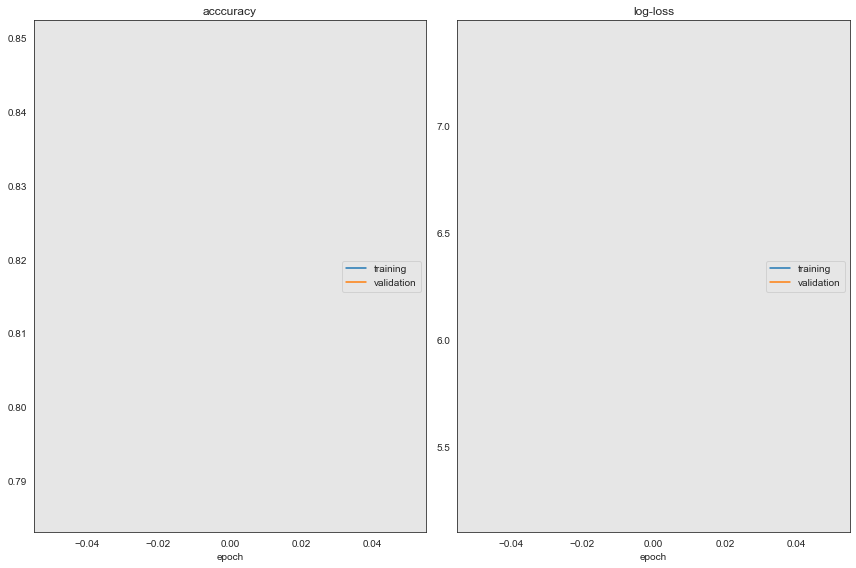

acccuracy
	training         	 (min:    0.786, max:    0.786, cur:    0.786)
	validation       	 (min:    0.849, max:    0.849, cur:    0.849)
log-loss
	training         	 (min:    7.382, max:    7.382, cur:    7.382)
	validation       	 (min:    5.210, max:    5.210, cur:    5.210)


In [121]:
plotlosses.send()

In [127]:
%matplotlib qt

In [128]:
c = plt.imshow(np.array(w).reshape(8,8), cmap = 'gray_r')
plt.colorbar(c)
figManager = plt.get_current_fig_manager()
figManager.window.showMaximized()

## Predicting and evaluating the trained classifier

In [123]:
test_threshold = .35
classification, readouts = predict(qubits = Q, X_test = X_test, negative_class = number_negative_class, positive_class = number_positive_class, shots = shots, threshold = test_threshold, w = weights[0], bias = bias)

In [129]:
accuracy, counts, confusion_matriX = evaluate(Y_test, classification, number_negative_class, number_positive_class)
print(f'Accuracy = {accuracy}')
print(f'Counts = {counts}')
print(f'Confusion Matrix = \n{confusion_matriX}')

Accuracy = 0.8491620111731844
Counts = Counter({9: 169, 0: 135})
Confusion Matrix = 
[[169.  11.]
 [ 43. 135.]]


In [130]:
plot_confusion_matrix(confusion_matriX, target_names = np.array([number_negative_class, number_positive_class]), labels = True, normalize = False)
figManager = plt.get_current_fig_manager()
figManager.window.showMaximized()

In [131]:
confusion_matriX

array([[169.,  11.],
       [ 43., 135.]])

In [132]:
accuracy_score(Y_test, classification)

0.8491620111731844

In [133]:
confusion_matrix(Y_test, classification)

array([[135,  43],
       [ 11, 169]], dtype=int64)

In [134]:
precision_score(Y_test, classification, average = 'binary', pos_label = number_negative_class)

0.7971698113207547

In [135]:
recall_score(Y_test, classification, average = 'binary', pos_label = number_negative_class)

0.9388888888888889

In [136]:
f1_score(Y_test, classification, average = 'binary', pos_label = number_negative_class)

0.8622448979591838

In [137]:
# Average Precision Score
precision_score(Y_test, classification, average = 'macro')

0.860913672783665

In [138]:
# Average Recall Score
recall_score(Y_test, classification, average = 'macro')

0.8486579275905118

In [139]:
# Average F1 Score
f1_score(Y_test, classification, average = 'macro')

0.8477891156462586

In [140]:
%%notify -o
f'The accuracy is {accuracy}.'

'The accuracy is 0.8491620111731844.'

<IPython.core.display.Javascript object>

In [141]:
from sklearn.metrics import roc_curve, auc

test = [0 if ele == number_negative_class else 1 for ele in Y_test]
classi = [0 if ele == number_negative_class else 1 for ele in classification]

fpr, tpr, thresholds = roc_curve(test, classi)

def ROC_curve(fpr,tpr):
    # Seaborn's beautiful styling
    sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
ROC_curve(fpr,tpr)
figManager = plt.get_current_fig_manager()
figManager.window.showMaximized()
sns.set_style('white', {'axes.facecolor': '0.9'})

AUC: 0.8486579275905118


## Manual process analysis

In [36]:
classification.astype(int)

array([0, 7, 0, 7, 0, 7, 0, 0, 7, 7, 0, 0, 7, 0, 7, 0, 0, 0, 7, 7, 7, 0,
       7, 7, 7, 0, 0, 7, 0, 7, 0, 7, 0, 0, 7, 7, 0, 0, 7, 0, 7, 0, 0, 0,
       7, 7, 7, 0, 7, 7, 0, 0, 7, 0, 7, 0, 7, 0, 0, 7, 7, 0, 0, 7, 0, 7,
       0, 0, 0, 7, 7, 7, 0, 7, 7, 7, 0, 0, 7, 0, 7, 0, 7, 0, 0, 7, 7, 0,
       0, 7, 0, 7, 0, 0, 0, 7, 7, 0, 0, 7, 7, 0, 0, 0, 7, 0, 7, 0, 7, 0,
       0, 7, 7, 0, 0, 7, 0, 7, 0, 0, 0, 7, 7, 7, 0, 7, 7, 7, 0, 0, 7, 0,
       7, 0, 7, 0, 0, 7, 7, 0, 0, 7, 7, 7, 0, 0, 0, 7, 7, 7, 0, 7, 7, 7,
       0, 0, 7, 0, 7, 0, 7, 0, 0, 7, 7, 0, 0, 7, 0, 7, 0, 0, 0, 7, 7, 7,
       0, 7, 7, 7, 0, 7, 0, 7, 0, 7, 0, 0, 7, 7, 7, 0, 7, 0, 0, 0, 7, 7,
       0, 7, 7, 7, 0, 0, 7, 0, 7, 0, 7, 0, 0, 7, 7, 7, 7, 7, 7, 7, 0, 0,
       0, 7, 7, 7, 0, 7, 7, 7, 0, 0, 7, 0, 7, 0, 7, 0, 0, 7, 7, 0, 0, 7,
       0, 7, 0, 7, 0, 7, 7, 0, 0, 7, 7, 7, 7, 0, 7, 0, 7, 0, 7, 0, 0, 7,
       7, 0, 0, 7, 0, 7, 0, 0, 0, 7, 7, 7, 0, 7, 7, 7, 0, 0, 7, 0, 7, 0,
       7, 0, 0, 7, 7, 0, 0, 7, 0, 7, 0, 0, 0, 7, 7,

In [37]:
Y_test

array([0, 7, 0, 7, 0, 7, 0, 0, 7, 7, 0, 0, 7, 0, 7, 0, 0, 0, 7, 7, 7, 0,
       7, 7, 7, 0, 0, 7, 0, 7, 0, 7, 0, 0, 7, 7, 0, 0, 7, 0, 7, 0, 0, 0,
       7, 7, 7, 0, 7, 7, 0, 0, 7, 0, 7, 0, 7, 0, 0, 7, 7, 0, 0, 7, 0, 7,
       0, 0, 0, 7, 7, 7, 0, 7, 7, 7, 0, 0, 7, 0, 7, 0, 7, 0, 0, 7, 7, 0,
       0, 7, 0, 7, 0, 0, 0, 7, 7, 7, 0, 7, 7, 7, 0, 0, 7, 0, 7, 0, 7, 0,
       0, 7, 7, 0, 0, 7, 0, 7, 0, 0, 0, 7, 7, 7, 0, 7, 7, 7, 0, 0, 7, 0,
       7, 0, 7, 0, 0, 7, 7, 0, 0, 7, 0, 7, 0, 0, 0, 7, 7, 7, 0, 7, 7, 7,
       0, 0, 7, 0, 7, 0, 7, 0, 0, 7, 7, 0, 0, 7, 0, 7, 0, 0, 0, 7, 7, 7,
       0, 7, 7, 7, 0, 7, 0, 7, 0, 7, 0, 0, 7, 7, 7, 0, 7, 0, 0, 0, 7, 7,
       0, 7, 7, 7, 0, 0, 7, 0, 7, 0, 7, 0, 0, 7, 7, 0, 0, 7, 0, 7, 0, 0,
       0, 7, 7, 7, 0, 7, 7, 7, 0, 0, 7, 0, 7, 0, 7, 0, 0, 7, 7, 0, 0, 7,
       0, 7, 0, 0, 0, 7, 7, 7, 0, 7, 7, 7, 0, 0, 7, 0, 7, 0, 7, 0, 0, 7,
       7, 0, 0, 7, 0, 7, 0, 0, 0, 7, 7, 7, 0, 7, 7, 7, 0, 0, 7, 0, 7, 0,
       7, 0, 0, 7, 7, 0, 0, 7, 0, 7, 0, 0, 0, 7, 7,

In [38]:
fails = np.where(classification != Y_test)[0]
print(fails)

[ 97 101 142 213 214 216 245 249 254]


In [39]:
X_test = np.array(X_test)
for x in X_test[fails]:
    print(np.power((np.where(weights[0] == x)[0].shape[0] - np.where(weights[0] != x)[0].shape[0]) / x.shape[0], 2))

0.3525390625
0.3525390625
0.3525390625
0.31640625
0.1650390625
0.3525390625
0.2822265625
0.3525390625
0.2822265625


In [40]:
print(np.sort(readouts[np.where(Y_test == number_negative_class)]), end = '\n\n')
print(np.sort(readouts[np.where(Y_test == number_positive_class)]))
print(np.sort(readouts[fails]))

[0.05065918 0.05700684 0.07275391 0.07971191 0.08117676 0.09973145
 0.10131836 0.11132812 0.11340332 0.1151123  0.11535645 0.11621094
 0.11694336 0.11791992 0.11853027 0.11901855 0.1192627  0.12109375
 0.12268066 0.1237793  0.13598633 0.13757324 0.13793945 0.13891602
 0.14038086 0.14221191 0.1427002  0.14367676 0.14746094 0.15637207
 0.15710449 0.15905762 0.16040039 0.16174316 0.1619873  0.16210938
 0.16271973 0.1628418  0.16296387 0.16320801 0.16540527 0.16564941
 0.16625977 0.16650391 0.16662598 0.16699219 0.16723633 0.16870117
 0.16931152 0.17077637 0.17077637 0.18273926 0.18457031 0.18481445
 0.18481445 0.18493652 0.18566895 0.18579102 0.18640137 0.18652344
 0.18652344 0.18688965 0.18725586 0.18811035 0.18823242 0.18823242
 0.18933105 0.18945312 0.18969727 0.18994141 0.19055176 0.19055176
 0.19067383 0.19128418 0.19152832 0.19213867 0.19226074 0.19250488
 0.19250488 0.19274902 0.19335938 0.19372559 0.19396973 0.19421387
 0.19519043 0.1953125  0.19580078 0.19592285 0.19616699 0.1965

In [41]:
fig, axs = plt.subplots(3, int(np.ceil(len(fails) / 3)), figsize=(15,9))
count = 0

for i in range(3):
    for j in range(int(np.ceil(len(fails) / 3))):
        ax = axs[i][j]
        
        #c = ax.pcolor(thetas[i + j][1:].reshape(28, 28), cmap = 'gray')
        try:
            c = ax.imshow(np.array(X_test[fails[count]]).reshape(8, 8), cmap = 'gray_r', interpolation='nearest')
            ax.axis('off')
            ax.axis('equal')
            ax.set_title(f'Classified as {classification[fails[count]]}').set_position([0.5, 1.1])
            count += 1
        except IndexError:
            continue
        
fig.tight_layout()
plt.colorbar(c)
plt.show()

In [42]:
Counter(Y_test)

Counter({0: 178, 7: 179})

In [43]:
readouts

array([0.61804199, 0.13793945, 0.43640137, 0.17077637, 0.66064453,
       0.12268066, 0.65734863, 0.60473633, 0.15637207, 0.22827148,
       0.76184082, 0.51464844, 0.22424316, 0.52050781, 0.27746582,
       0.60913086, 0.82092285, 0.765625  , 0.22631836, 0.21801758,
       0.16870117, 0.42407227, 0.31933594, 0.24621582, 0.27392578,
       0.60876465, 0.71533203, 0.21447754, 0.61376953, 0.21862793,
       0.66491699, 0.18652344, 0.61938477, 0.6072998 , 0.11694336,
       0.13891602, 0.60986328, 0.46972656, 0.21484375, 0.60839844,
       0.11791992, 0.72143555, 0.6081543 , 0.47058105, 0.24511719,
       0.24536133, 0.11853027, 0.7175293 , 0.28356934, 0.19335938,
       0.66345215, 0.51696777, 0.12109375, 0.64575195, 0.25073242,
       0.65917969, 0.1953125 , 0.55859375, 0.47155762, 0.22412109,
       0.16564941, 0.77050781, 0.76623535, 0.19274902, 0.66381836,
       0.08117676, 0.61279297, 0.65673828, 0.6159668 , 0.24682617,
       0.21228027, 0.22619629, 0.60473633, 0.18579102, 0.19396

In [44]:
indexes = [i for i in range(len(readouts))]

In [45]:
list(zip(indexes, Y_test, readouts))

[(0, 0, 0.6180419921875),
 (1, 7, 0.137939453125),
 (2, 0, 0.4364013671875),
 (3, 7, 0.1707763671875),
 (4, 0, 0.66064453125),
 (5, 7, 0.1226806640625),
 (6, 0, 0.6573486328125),
 (7, 0, 0.604736328125),
 (8, 7, 0.1563720703125),
 (9, 7, 0.228271484375),
 (10, 0, 0.7618408203125),
 (11, 0, 0.5146484375),
 (12, 7, 0.2242431640625),
 (13, 0, 0.5205078125),
 (14, 7, 0.2774658203125),
 (15, 0, 0.609130859375),
 (16, 0, 0.8209228515625),
 (17, 0, 0.765625),
 (18, 7, 0.226318359375),
 (19, 7, 0.218017578125),
 (20, 7, 0.168701171875),
 (21, 0, 0.424072265625),
 (22, 7, 0.3193359375),
 (23, 7, 0.2462158203125),
 (24, 7, 0.27392578125),
 (25, 0, 0.6087646484375),
 (26, 0, 0.71533203125),
 (27, 7, 0.2144775390625),
 (28, 0, 0.61376953125),
 (29, 7, 0.2186279296875),
 (30, 0, 0.6649169921875),
 (31, 7, 0.1865234375),
 (32, 0, 0.619384765625),
 (33, 0, 0.6072998046875),
 (34, 7, 0.116943359375),
 (35, 7, 0.138916015625),
 (36, 0, 0.60986328125),
 (37, 0, 0.4697265625),
 (38, 7, 0.21484375),
 (39,

In [46]:
#%matplotlib qt
plt.scatter(Y_train, m[-1])
plt.xlabel("Number")
plt.ylabel("Training Readout")
#%matplotlib inline

Text(0, 0.5, 'Training Readout')

In [47]:
#%matplotlib qt
plt.scatter(Y_test, readouts)
plt.xlabel("Number")
plt.ylabel("Prediction Readout")
plt.plot([i for i in range(number_negative_class, number_positive_class + 1)], [test_threshold for _ in range(number_negative_class, number_positive_class + 1)])
plt.plot([i for i in range(min(number_negative_class, number_positive_class), max(number_negative_class, number_positive_class) + 1)], [test_threshold for _ in range(abs(number_negative_class - number_positive_class) + 1)])
#%matplotlib inline

In [48]:
classification_auxiliar = classification / np.max(classification)
palette = np.array(sns.color_palette("hls", 2))  #Choosing color palette 
plt.scatter(Y_test, readouts, lw=0, s=40, c=palette[classification_auxiliar.astype(np.int)])
plt.plot([i for i in range(number_negative_class, number_positive_class + 1)], [test_threshold for _ in range(number_negative_class, number_positive_class + 1)])

In [49]:
Y_test

array([0, 7, 0, 7, 0, 7, 0, 0, 7, 7, 0, 0, 7, 0, 7, 0, 0, 0, 7, 7, 7, 0,
       7, 7, 7, 0, 0, 7, 0, 7, 0, 7, 0, 0, 7, 7, 0, 0, 7, 0, 7, 0, 0, 0,
       7, 7, 7, 0, 7, 7, 0, 0, 7, 0, 7, 0, 7, 0, 0, 7, 7, 0, 0, 7, 0, 7,
       0, 0, 0, 7, 7, 7, 0, 7, 7, 7, 0, 0, 7, 0, 7, 0, 7, 0, 0, 7, 7, 0,
       0, 7, 0, 7, 0, 0, 0, 7, 7, 7, 0, 7, 7, 7, 0, 0, 7, 0, 7, 0, 7, 0,
       0, 7, 7, 0, 0, 7, 0, 7, 0, 0, 0, 7, 7, 7, 0, 7, 7, 7, 0, 0, 7, 0,
       7, 0, 7, 0, 0, 7, 7, 0, 0, 7, 0, 7, 0, 0, 0, 7, 7, 7, 0, 7, 7, 7,
       0, 0, 7, 0, 7, 0, 7, 0, 0, 7, 7, 0, 0, 7, 0, 7, 0, 0, 0, 7, 7, 7,
       0, 7, 7, 7, 0, 7, 0, 7, 0, 7, 0, 0, 7, 7, 7, 0, 7, 0, 0, 0, 7, 7,
       0, 7, 7, 7, 0, 0, 7, 0, 7, 0, 7, 0, 0, 7, 7, 0, 0, 7, 0, 7, 0, 0,
       0, 7, 7, 7, 0, 7, 7, 7, 0, 0, 7, 0, 7, 0, 7, 0, 0, 7, 7, 0, 0, 7,
       0, 7, 0, 0, 0, 7, 7, 7, 0, 7, 7, 7, 0, 0, 7, 0, 7, 0, 7, 0, 0, 7,
       7, 0, 0, 7, 0, 7, 0, 0, 0, 7, 7, 7, 0, 7, 7, 7, 0, 0, 7, 0, 7, 0,
       7, 0, 0, 7, 7, 0, 0, 7, 0, 7, 0, 0, 0, 7, 7,

In [50]:
plt.imshow(np.array(X_test[2]).reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')

In [51]:
np.array(X_test[2]).reshape(8,8)

array([[0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 1., 1., 0., 1., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0.]])

In [52]:
import seaborn as sns
sns.set_style('white')
sns.distplot(readouts, kde=False)

In [53]:
palette = np.array(sns.color_palette("hls", 2))  #Choosing color palette 
plt.scatter(Y_train, m[-1], lw=0, s=40, c=palette[m[-1].astype(np.int)])
plt.plot([i for i in range(number_negative_class, number_positive_class + 1)], [test_threshold for _ in range(number_negative_class, number_positive_class + 1)])

In [142]:
filename = 'weights_OvO_FullDataSet.txt'
mode = 'a+'
save_weight(filename = filename, mode = mode, weight = w)

# Multi label prediction

In [10]:
weights_matrix = retrieve_weights_from_file(filename = 'weights_OvO_FullDataSet.txt', full = True)

In [11]:
print_weights_matrix(weights_matrix)

In [7]:
print(weights_matrix)

[[array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
  array([1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1])
  array([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1])
  array([1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1])
  array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 

In [8]:
digits = datasets.load_digits()

# Getting images and labels from digits
images = digits.images
targets = digits.target

print(f'Total count for digits: {Counter(targets)}')
# Splitting dataset
#X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(images, targets, test_size = 0.2, random_state = 10, shuffle = True)
X_test, Y_test = images, targets

Total count for digits: Counter({3: 183, 1: 182, 5: 182, 4: 181, 6: 181, 9: 180, 7: 179, 0: 178, 2: 177, 8: 174})


In [9]:
images_and_labels = list(zip(X_test, Y_test))
for index, (image, label) in enumerate(images_and_labels[:20]):
    plt.subplot(2, 10, index + 1)
    plt.axis('off')
    plt.imshow(image.reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Test: %i' % label)

In [10]:
# Reshaping digits
#X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)


# Preprocessing digits by mapping in interval
for i in range(len(X_test)):
    X_test[i] = np.array(list(map(lambda x : 0 if 0 <= x < 9 else 1, X_test[i])))
    
#for i in range(len(X_train)):
#    X_train[i] = np.array(list(map(lambda x : 0 if 0 <= x < 9 else 1, X_train[i])))

In [11]:
images_and_labels = list(zip(X_test, Y_test))
for index, (image, label) in enumerate(images_and_labels[:20]):
    plt.subplot(2, 10, index + 1)
    plt.axis('off')
    plt.imshow(image.reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Test: %i' % label)

In [13]:
N = -1
test_threshold = .35
Q = 6
classification_patterns = X_test[:]
classification_labels = Y_test[:]
shots = 1024 * 8
bias = 0.0

classified_as, holder_for_most_common, holder_for_test, holder_for_readouts = multi_class_prediction(qubits = Q, classification_patterns = classification_patterns, shots = shots, test_threshold = test_threshold, weights_matrix = weights_matrix, bias = bias)

C:\Users\jeff_\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


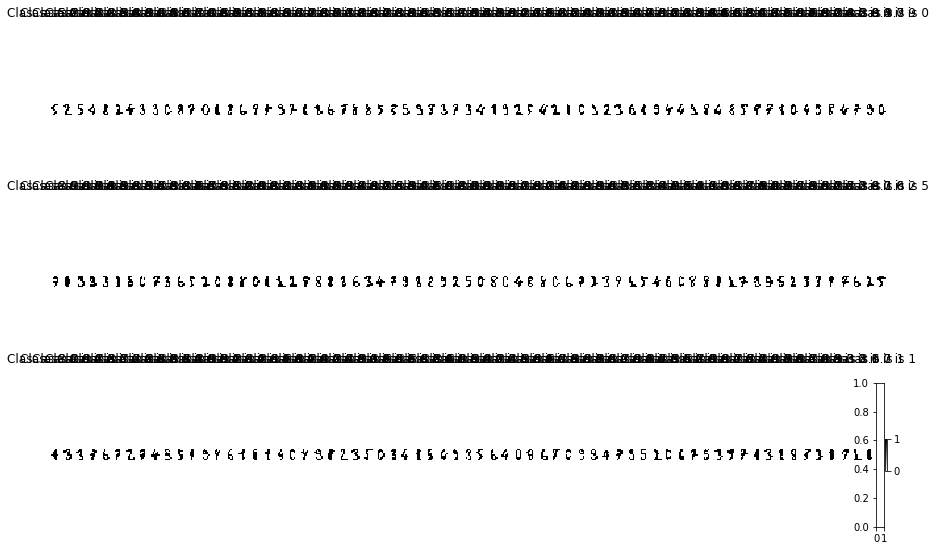

In [11]:
fig, axs = plt.subplots(3, int(np.ceil(len(classification_patterns) / 3)), figsize=(15,9))
count = 0

for i in range(3):
    for j in range(int(np.ceil(len(classification_patterns) / 3))):
        ax = axs[i][j]
        
        #c = ax.pcolor(thetas[i + j][1:].reshape(28, 28), cmap = 'gray')
        try:
            c = ax.imshow(np.array(classification_patterns[count]).reshape(8, 8), cmap = 'gray_r', interpolation='nearest')
            ax.axis('off')
            ax.axis('equal')
            ax.set_title(f'Clas. as {classified_as[count]} is {classification_labels[count]}').set_position([0.5, 1.1])
            count += 1
        except IndexError:
            continue
        
fig.tight_layout()
plt.colorbar(c)
plt.show()

In [14]:
accuracy = len(np.where(classification_labels == classified_as)[0]) / len(classification_labels)
print(f'Accuracy = {accuracy}')

Accuracy = 0.5698386199220924


In [15]:
holder_for_test

array([[[0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 1.0, 1.0, ..., 1.0, 8.0, 9.0],
        [0.0, 1.0, 2.0, ..., 2.0, 8.0, 9.0],
        ...,
        [0.0, 1.0, 2.0, ..., 7.0, 8.0, 9.0],
        [0.0, 8.0, 8.0, ..., 8.0, 8.0, 9.0],
        [0.0, 9.0, 9.0, ..., 9.0, 9.0, 9.0]],

       [[0.0, 1.0, 0.0, ..., 0.0, 8.0, 9.0],
        [1.0, 1.0, 1.0, ..., 1.0, 1.0, 1.0],
        [0.0, 1.0, 2.0, ..., 2.0, 2.0, 2.0],
        ...,
        [0.0, 1.0, 2.0, ..., 7.0, 7.0, 9.0],
        [8.0, 1.0, 2.0, ..., 7.0, 8.0, 8.0],
        [9.0, 1.0, 2.0, ..., 9.0, 8.0, 9.0]],

       [[0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 1.0, 1.0, ..., 1.0, 1.0, 1.0],
        [0.0, 1.0, 2.0, ..., 2.0, 2.0, 2.0],
        ...,
        [0.0, 1.0, 2.0, ..., 7.0, 7.0, 7.0],
        [0.0, 1.0, 2.0, ..., 7.0, 8.0, 8.0],
        [0.0, 1.0, 2.0, ..., 7.0, 8.0, 9.0]],

       ...,

       [[0.0, 1.0, 0.0, ..., 0.0, 8.0, 0.0],
        [1.0, 1.0, 1.0, ..., 1.0, 8.0, 1.0],
        [0.0, 1.0, 2.0, ..., 2.0, 8.0, 2.0

In [16]:
# To print only two decimal places
np.set_printoptions(precision=2)

In [17]:
holder_for_readouts.astype(float)

array([[[0.66, 0.16, 0.19, ..., 0.22, 0.34, 0.32],
        [0.16, 0.11, 0.28, ..., 0.19, 0.53, 0.39],
        [0.19, 0.28, 0.31, ..., 0.22, 0.43, 0.39],
        ...,
        [0.22, 0.19, 0.22, ..., 0.19, 0.51, 0.38],
        [0.34, 0.53, 0.43, ..., 0.51, 0.29, 0.38],
        [0.32, 0.39, 0.39, ..., 0.38, 0.38, 0.25]],

       [[0.14, 0.6 , 0.32, ..., 0.28, 0.51, 0.39],
        [0.6 , 0.42, 0.22, ..., 0.24, 0.28, 0.2 ],
        [0.32, 0.22, 0.32, ..., 0.28, 0.27, 0.19],
        ...,
        [0.28, 0.24, 0.28, ..., 0.25, 0.28, 0.38],
        [0.51, 0.28, 0.27, ..., 0.28, 0.28, 0.19],
        [0.39, 0.2 , 0.19, ..., 0.38, 0.19, 0.2 ]],

       [[0.09, 0.28, 0.14, ..., 0.17, 0.29, 0.14],
        [0.28, 0.35, 0.22, ..., 0.26, 0.23, 0.19],
        [0.14, 0.22, 0.15, ..., 0.17, 0.16, 0.1 ],
        ...,
        [0.17, 0.26, 0.17, ..., 0.25, 0.17, 0.2 ],
        [0.29, 0.23, 0.16, ..., 0.17, 0.11, 0.09],
        [0.14, 0.19, 0.1 , ..., 0.2 , 0.09, 0.14]],

       ...,

       [[0.33, 0.43, 0.2

In [18]:
fig, axs = plt.subplots(2,5, figsize=(15,9))
count = 0

for i in range(2):
    for j in range(5):
        ax = axs[i][j]
        
        #c = ax.pcolor(thetas[i + j][1:].reshape(28, 28), cmap = 'gray')
        try:
            c = ax.imshow(np.array(np.nan_to_num(holder_for_readouts.astype(float))[count].reshape(10,10)), cmap = 'hot', interpolation='nearest')
            ax.axis('on')
            #ax.axis('equal')
            ax.set_title(f'Clas. as {classified_as[count]} is {classification_labels[count]}').set_position([0.5, 1.1])
            count += 1
        except IndexError:
            continue
        
fig.tight_layout()
norm = mpl.colors.Normalize(vmin=np.nan_to_num(holder_for_readouts.astype(float)).min(), vmax=np.nan_to_num(holder_for_readouts.astype(float)).max())
plt.colorbar(c, norm = norm)
plt.show()

In [19]:
np.nan_to_num(holder_for_readouts.astype(float))[9].flatten().argsort()[98:]

array([32, 33], dtype=int64)

In [21]:
np.argmax(np.nan_to_num(holder_for_readouts.astype(float)), axis = 1)

array([[0, 8, 8, ..., 8, 1, 4],
       [1, 0, 5, ..., 9, 0, 0],
       [8, 1, 1, ..., 4, 3, 7],
       ...,
       [8, 6, 5, ..., 8, 3, 0],
       [8, 6, 9, ..., 9, 9, 8],
       [6, 9, 6, ..., 9, 8, 1]], dtype=int64)

In [22]:
np.array(list(map(np.argmax, np.nan_to_num(holder_for_readouts.astype(float)))))

array([ 0,  1, 38, ..., 25, 33, 19], dtype=int64)

In [23]:
trick = np.array(list(map(np.argmax, np.nan_to_num(holder_for_readouts.astype(float))))) % 10
trick

array([0, 1, 8, ..., 5, 3, 9], dtype=int64)

In [24]:
classification_labels

array([0, 1, 2, ..., 8, 9, 8])

In [25]:
accuracy = len(np.where(classification_labels == trick)[0]) / len(classification_labels)
print(f'Accuracy = {accuracy}')

Accuracy = 0.7089593767390094


In [34]:
np.nan_to_num(holder_for_readouts.astype(float))[9].flatten().argsort()[98:]
np.array(list(map(np.argsort, np.nan_to_num(holder_for_readouts.astype(float).reshape(1797, -1)))))[:, :]
another_trick = np.array(list(map(np.argsort, np.nan_to_num(holder_for_readouts.astype(float).reshape(1797, -1)))))[:,:]
print(another_trick)

another_trick = another_trick[:, 0]
another_trick = np.array(list(map(lambda x : x//10 if x > 9 else x, another_trick)))
print(another_trick)

[[11  1 10 ... 81 18  0]
 [66 49 94 ... 80  1 10]
 [66 46 64 ... 11 38 83]
 ...
 [41 14 92 ... 38 52 25]
 [24 42  4 ... 98 89 33]
 [17 71 41 ... 26 91 19]]
[1 6 6 ... 4 2 1]


In [35]:
accuracy = len(np.where(classification_labels == another_trick)[0]) / len(classification_labels)
print(f'Accuracy = {accuracy}')

Accuracy = 0.021702838063439065


In [29]:
holder_for_most_common

array([[(0.0, 9), (3.0, 8), (8.0, 8), ..., (6.0, 4), (2.0, 3), (0.0, 1)],
       [(1.0, 10), (5.0, 8), (2.0, 7), ..., (9.0, 4), (6.0, 2), (7.0, 2)],
       [(0.0, 10), (1.0, 9), (2.0, 8), ..., (7.0, 4), (8.0, 3), (0.0, 1)],
       ...,
       [(8.0, 9), (0.0, 8), (1.0, 8), ..., (5.0, 5), (7.0, 3), (0.0, 1)],
       [(0.0, 8), (3.0, 8), (1.0, 7), ..., (5.0, 3), (7.0, 3), (8.0, 2)],
       [(2.0, 8), (0.0, 7), (3.0, 7), ..., (9.0, 4), (7.0, 3), (8.0, 2)]],
      dtype=object)

In [30]:
classification_labels

array([0, 1, 2, ..., 8, 9, 8])

In [31]:
np.array(classified_as).astype(int)

array([0, 1, 0, ..., 8, 0, 2])